Всё делал в гугл коллабе, потому что у меня вафельница вместо компьютера, так что почистил поля, где устанавливался кэтбуст и STOPWORDS, чтобы блокнот было возможно читать без боли.

In [ ]:
! pip install catboost
! pip install -q kaggle
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c two-sigma-connect-rental-listing-inquiries
! mkdir sigma
! unzip two-sigma-connect-rental-listing-inquiries.zip -d sigma


In [ ]:
cd sigma

In [ ]:
! unzip train.json.zip 
! unzip test.json.zip  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk 
nltk.download()

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier

%matplotlib inline

In [ ]:
df_original = pd.read_json("train.json")
df_original.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


В датасете есть даты, цифры, текст и изображения, - фичи разных типов. Конечно, состояние квартиры это важный параметр, который можно определить по фото, но это было бы очень трудоёмкой задачей, поэтому в будущем, возможно,просто посмотрю, зависит ли таргет от количества фото. Возможно, от некоторых колонок, включая фото, можно будет избавиться.
Бегло посмотрим на дату.

In [ ]:
df = df_original.copy(deep = True)

In [ ]:
 df.shape

(49352, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [ ]:
df.dtypes

bathrooms          float64
bedrooms             int64
building_id         object
created             object
description         object
display_address     object
features            object
latitude           float64
listing_id           int64
longitude          float64
manager_id          object
photos              object
price                int64
street_address      object
interest_level      object
dtype: object

In [ ]:
df['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

Объявлений с низкой востребованностью в разы больше, чем остальных. Датасет несбалансирован.
Посмотрим на числовые фичи: bathrooms, bedrooms, price

### bathrooms

In [ ]:
df['bathrooms'].value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
6.5         1
7.0         1
10.0        1
Name: bathrooms, dtype: int64

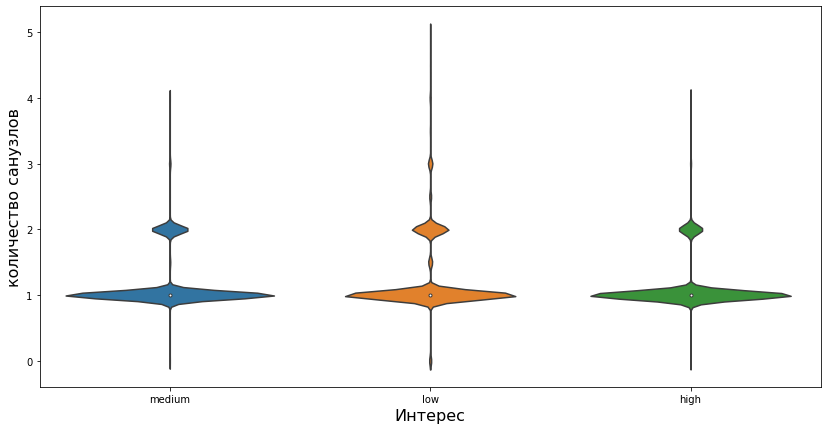

In [ ]:

plt.figure(figsize = (14,7))
sns.violinplot(x = 'interest_level', y = 'bathrooms', data = df.loc[df["bathrooms"]<=5])
plt.xlabel('Интерес', fontsize = 16)
plt.ylabel('количество санузлов', fontsize = 16)
plt.show()

### bedrooms

In [ ]:
df['bathrooms'].value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
6.5         1
7.0         1
10.0        1
Name: bathrooms, dtype: int64

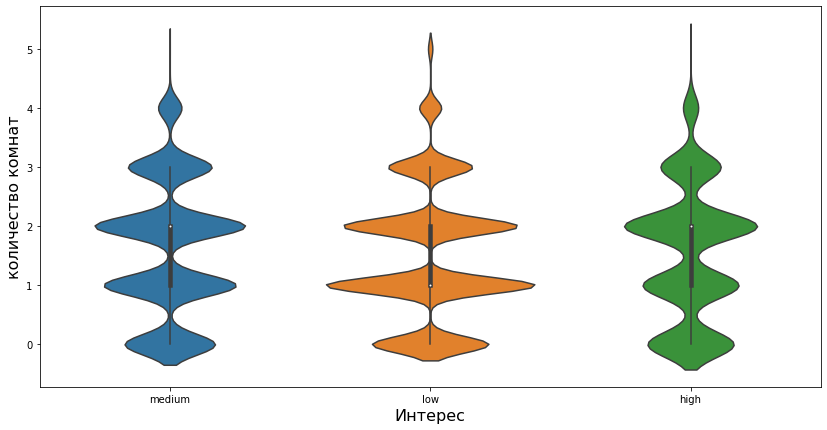

In [ ]:

plt.figure(figsize=(14,7))
sns.violinplot(x = 'interest_level', y = 'bedrooms', data = df.loc[df["bedrooms"]<=5])
plt.xlabel('Интерес', fontsize = 16)
plt.ylabel('количество комнат', fontsize = 16)
plt.show()

### price

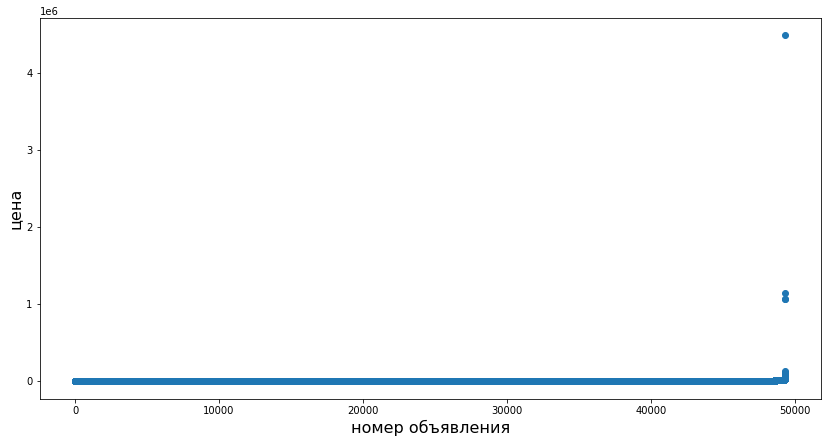

In [ ]:
plt.figure(figsize = (14,7))
plt.scatter(range(df.shape[0]), np.sort(df.price.values))
plt.xlabel('номер объявления', fontsize = 16)
plt.ylabel('цена', fontsize = 16)
plt.show()

Выбросы портят картину. Уберём первый и последний персентили. Для обучения их все равно брать не будем, чтобы исключить выбросы, так что можно сразу убирать из датасета.

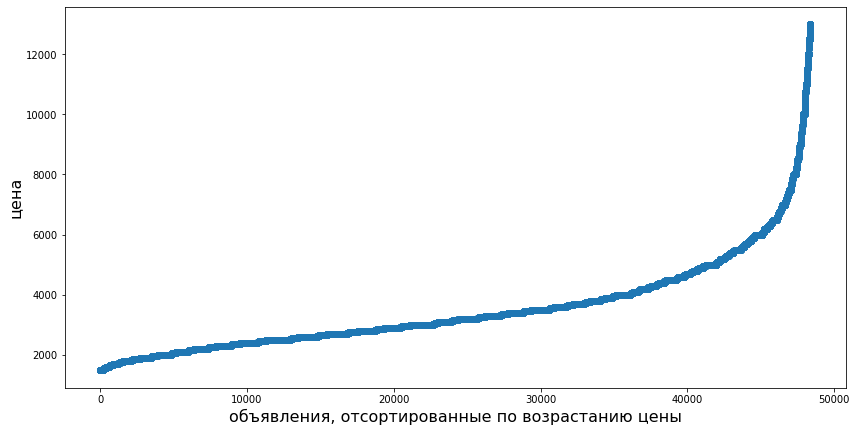

In [ ]:
price_lower_limit = np.percentile(df.price.values, 1)
price_upper_limit = np.percentile(df.price.values, 99)

df = df.loc[(df["price"]<=price_upper_limit) & (df["price"]>=price_lower_limit)]
plt.figure(figsize = (14,7))

plt.scatter(range(df.shape[0]), 
            np.sort(df.price.values))
plt.xlabel('объявления, отсортированные по возрастанию цены', fontsize = 16)
plt.ylabel('цена', fontsize = 16)
plt.show()

Получше. Посмотрим, как распределены цены.

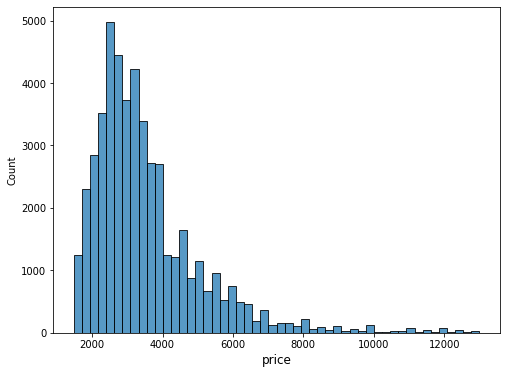

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(df.price.values, bins=50)
plt.xlabel('price', fontsize=12)
plt.show()

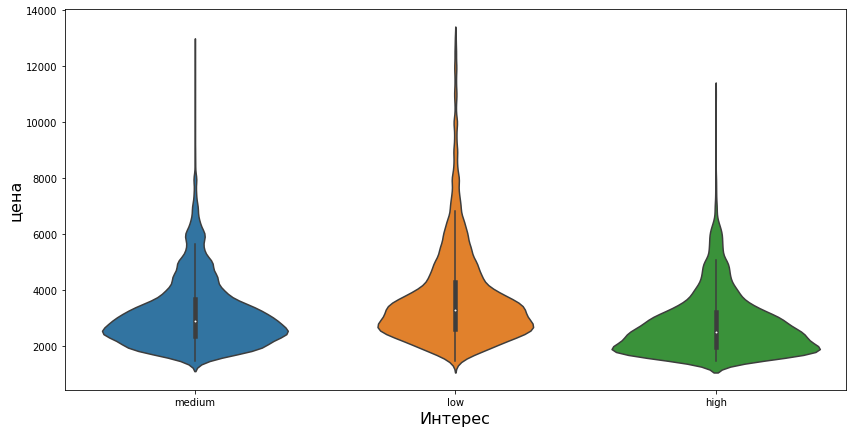

In [ ]:
plt.figure(figsize=(14,7))
sns.violinplot(x = 'interest_level', y = 'price', data = df)
plt.xlabel('Интерес', fontsize = 16)
plt.ylabel('ценa', fontsize = 16)
plt.show()

Похоже, что наибольший интерес люди проявляют к дешевым квартирам, а остальные числовые признаки не очень решают.

### geospatial

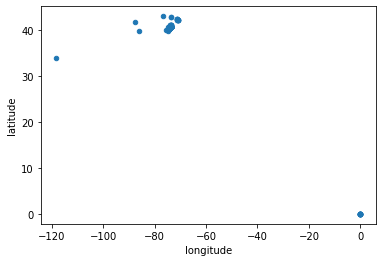

In [ ]:
df.plot(kind="scatter", x="longitude", y="latitude")

Снова уберем выбросы и сделаем красиво, чтобы было видно, где находится дорогая недвижимость.

In [ ]:
low_lat_limit = np.percentile(df.latitude.values, 1)
upper_lat_limit = np.percentile(df.latitude.values, 99)
low_lon_limit = np.percentile(df.longitude.values, 1)
upper_lon_limit = np.percentile(df.longitude.values, 99)

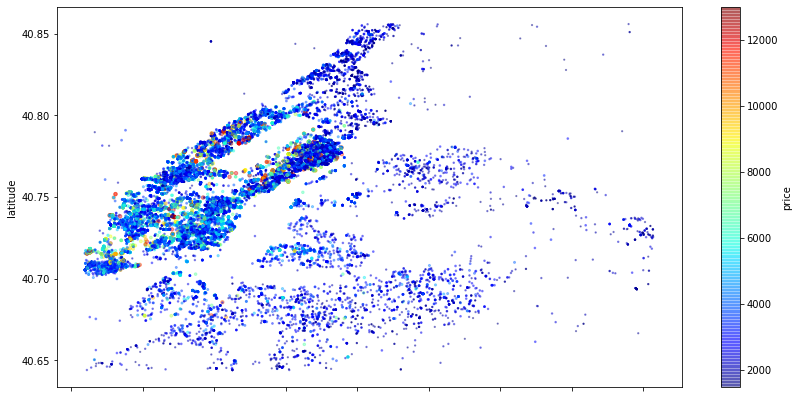

In [ ]:
df = df.loc[(df["latitude"] < upper_lat_limit) & 
       (df["latitude"] > low_lat_limit) & 
       (df["longitude"] < upper_lon_limit) & 
       (df["longitude"] > low_lon_limit)]
      
df.plot(kind="scatter", x="longitude", y="latitude", figsize = (14, 7),
            alpha = 0.4, s =df["price"].values/1000 , 
            c = "price", cmap=plt.get_cmap("jet"),
              colorbar = True)

### date

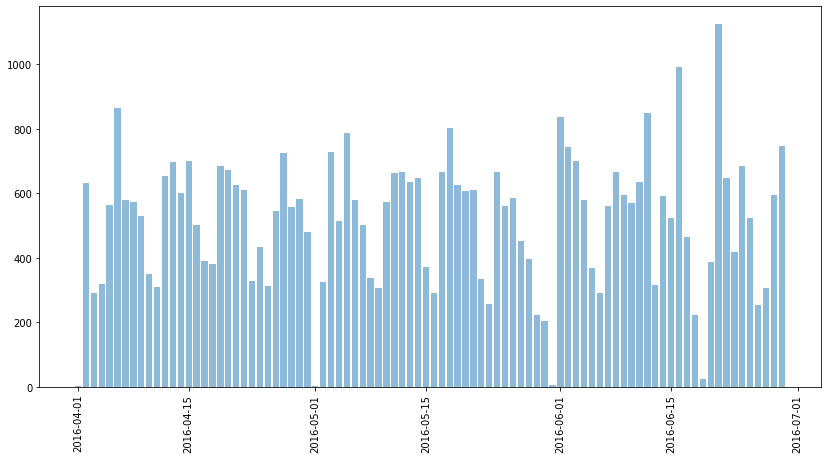

In [ ]:
dates = pd.to_datetime(df["created"]).dt.date.value_counts()

plt.figure(figsize=(14,7))
ax = plt.subplot()
ax.bar(dates.index, dates.values, alpha=0.5)
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.show()

Тут без выбросов - все объявления с апреля по июль одного года.

Ссылки на фото сломаны, из них ничего не вытащить, кроме количества фото, так что нужно будет заменить столбец в пайплайне, а пока что сделаем новый и посмотрим на его график.

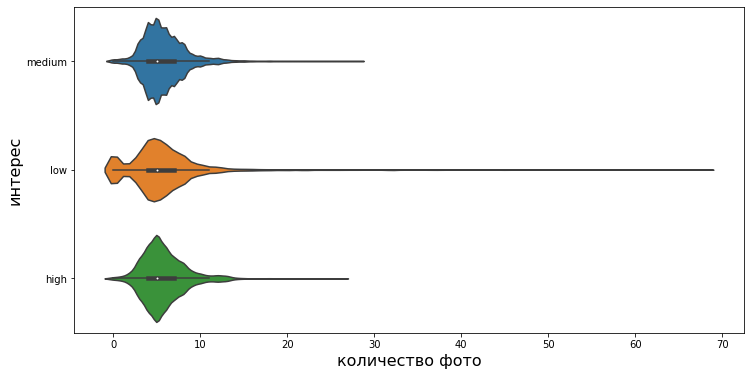

In [ ]:
df["photo_amount"] = df["photos"].apply(len)
plt.figure(figsize=(12,6))
sns.violinplot(x="photo_amount", y="interest_level", data=df)
plt.xlabel('количество фото', fontsize=16)
plt.ylabel('интерес', fontsize=16)
plt.show()
df.drop("photo_amount", axis = 1, inplace = True)

Поля building_id, display_address, listing_id, manager_id и street_address, полагаю, можно удалить, поскольку вместо адресов у нас уже есть очень точные координаты домов, а остальные данные нужны скорее для поиска и учёта в реестре, чем для определения цены и спроса на недвижимость.

### features

Времени для NLP совсем нет, так что можно посмотреть, как на спрос влияет количество фичей в описании. Возможно, бОльшим спросом пользуются квартиры с бОльшим количеством тэгов, по которым их ищут. 

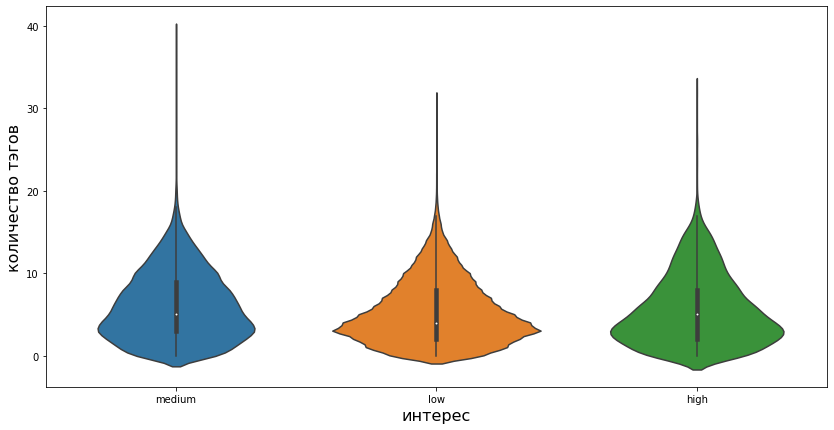

In [ ]:
df["features_amount"] = df["features"].apply(len)
plt.figure(figsize = (14,7))
sns.violinplot(y = "features_amount", x = "interest_level", data=df)
plt.xlabel('интерес', fontsize=16)
plt.ylabel('количество тэгов', fontsize=16)
plt.show()
df.drop(["features_amount"], inplace = True, axis = 1)

Удалим ненужные столбцы, превратим поле features из листа в текст, чтобы кэтбуст мог с ним работать. Пустые листы превратятся в пустые строки, заполненные одним пробелом. Также приведём весь текст к нижнему регистру и удалим все, кроме слов и чисел.

In [ ]:
df_test = df
text_features = ["description", "features", "display_address"]

def df_transform(df, text_features):

    def get_rid_of_non_words(text):
        return re.sub(r'[^A-Za-z0-9 ]', '', text) #delete everything that is not a letter/number/whitespace

    def remove_stopwords(text):
        final_text = []
        for i in text.split():
            if i.lower() not in STOPWORDS:
                final_text.append(i)
        return " ".join(final_text)
    df.reset_index(drop = True, inplace = True)
    labels = False
    if "interest_level" in list(df.columns):
        labels = df["interest_level"]
        df.drop("interest_level", inplace = True, axis = 1)
    df.drop(["building_id","manager_id", "street_address", "created"],
                        inplace = True, axis = 1)
    df["features"] = df["features"].apply(", ".join)
    for feature in text_features:
        df[feature] = df[feature].str.lower().apply(get_rid_of_non_words).apply(remove_stopwords)

    df["photos"] = df["photos"].apply(len)
    if type(labels) != bool:
      return df, labels
    else:
      return df

df_test, df_test_labels= df_transform(df_test, text_features)
df_test.drop("listing_id", inplace = True, axis = 1)
df_test.head()


,bathrooms,bedrooms,description,display_address,features,latitude,listing_id,longitude,photos,price
0,1.0,1,spacious 1 bedroom 1 bathroom williamsburgapar...,145 borinquen place,dining room prewar laundry building dishwasher...,40.7108,7170325,-73.9539,12,2400
1,1.0,2,brand new gut renovated true 2 bedroomfind hom...,east 44th,doorman elevator laundry building dishwasher h...,40.7513,7092344,-73.9722,6,3800
2,1.0,2,flex 2 bedroom full pressurized walllooking pe...,east 56th street,doorman elevator laundry building laundry unit...,40.7575,7158677,-73.9625,6,3495
3,1.5,3,brand new 3 bedroom 15 bath apartmentenjoy fol...,metropolitan avenue,,40.7145,7211212,-73.9425,5,3000
4,1.0,0,oversized studio w abundant closets available ...,east 34th street,doorman elevator fitness center laundry building,40.7439,7225292,-73.9743,4,2795


Делим на трейн и тест, создаём пулы, тренируем модель.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_test, df_test_labels, 
                                                    train_size=0.70, 
                                                    random_state=42)

In [ ]:
def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        X_train, 
        y_train, 
        text_features=text_features,
        feature_names=list(X_train)
    )
    test_pool = Pool(
        X_test, 
        y_test,
        text_features=text_features,
        feature_names=list(X_train)
    )
    
    catboost_default_params = {
        'iterations': 1500,
        'learning_rate': 0.05,
        'objective': 'MultiClass',
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

model = fit_catboost(X_train, X_test, y_train, y_test)

0:	learn: 1.0630233	test: 1.0626968	best: 1.0626968 (0)	total: 2.48s	remaining: 1h 1m 51s
100:	learn: 0.6356783	test: 0.6274522	best: 0.6274522 (100)	total: 3m 53s	remaining: 53m 56s
200:	learn: 0.6105704	test: 0.6089461	best: 0.6089461 (200)	total: 7m 11s	remaining: 46m 30s
300:	learn: 0.5874637	test: 0.5951557	best: 0.5951557 (300)	total: 10m 29s	remaining: 41m 46s
400:	learn: 0.5747489	test: 0.5895473	best: 0.5895473 (400)	total: 13m 43s	remaining: 37m 37s
500:	learn: 0.5643487	test: 0.5855585	best: 0.5855585 (500)	total: 16m 55s	remaining: 33m 44s
600:	learn: 0.5557841	test: 0.5824597	best: 0.5824597 (600)	total: 20m 11s	remaining: 30m 12s
700:	learn: 0.5480574	test: 0.5801616	best: 0.5801503 (698)	total: 23m 31s	remaining: 26m 49s
800:	learn: 0.5412535	test: 0.5787409	best: 0.5787196 (799)	total: 26m 51s	remaining: 23m 26s
900:	learn: 0.5351744	test: 0.5773562	best: 0.5773562 (900)	total: 30m 30s	remaining: 20m 16s
1000:	learn: 0.5293672	test: 0.5759370	best: 0.5759370 (1000)	tota

Трансформируем тестовый датафрейм, склеиваем всё для отправки результата и отправляем.

In [ ]:
final_test = pd.read_json("test.json")

In [ ]:
df_transform(final_test, text_features)

listings = final_test["listing_id"]
final_test.drop("listing_id", inplace = True, axis = 1)

In [ ]:
scores = model.predict_proba(final_test, 
              ntree_start=0, 
              ntree_end=0, 
              thread_count=-1, 
              verbose=None)

In [ ]:
final_df = pd.DataFrame(scores, columns = ["high", "low", "medium"])
final_df["listing_id"] = listings
final_df = final_df[["listing_id", "high", "medium", "low"]]
final_df.to_csv("submission.csv", index = False)

In [ ]:
!kaggle competitions submit -c two-sigma-connect-rental-listing-inquiries -f submission.csv -m "Late submission"

100% 4.78M/4.78M [00:01<00:00, 2.86MB/s]
Successfully submitted to Two Sigma Connect: Rental Listing Inquiries